In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
sns.set_context("notebook", font_scale=1.5)
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.model_selection import cross_val_score , cross_validate
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

### 2.1.1 인공 뉴런의 수학적 정의

$z = w_1x_1+\cdots+w_mx_m=\sum_{j=1}^mx_jw_j=\boldsymbol{w}^T\boldsymbol{x}$

퍼셉트론의 결정 함수 : $\phi(z)=\begin{cases}1&z\ge\theta\mbox{ 일 때} \\ -1&\mbox{그 외}\end{cases}$
$\;\;\;\;\;$

음수 임계값, 또는 가중치 $w_0 = -\theta$ 를 *절편* 이라고 한다

### 2.1.2 퍼셉트론 학습 규칙

Rosenblatt의 임계 퍼셉트론 모델은 "출력을 내거나 내지 않는 두 가지 경우만 있다."<br><br>
퍼셉트론 알고리즘을 요약하면..
1. 가중치를 0 또는 랜덤한 작은 값으로 초기화한다.
2. 각 훈련 샘플 $x^{(i)}$에서 다음 작업을 한다.
    1. 출력 값 $\hat{y}$를 계산한다.
    2. 가중치를 업데이트한다.

> $x_1^{(2)}$ 는 x의 1번째 feature의 (2)번째 데이터

$\Delta w_j = \eta(y^{(i)}-\hat{y}^{(i)})x_j^{(i)}$ <br>
$y^{(i)}=1,\;\hat{y}^{(i)}=-1, \qquad \Delta w_j=\eta(1-(-1))x_j^{(i)}=\eta(2)x_j^{(i)}$ <br>
$w_j := w_j + \Delta w_j$
> => $w_j$ j번째 feature의 가중치가 업데이트되는 방식은..<br>
> i번째 행의 $\hat{y}$ 과 $y$가 같다면 업데이트 하지 않고,<br>
> 다르다면 이를 x의 j번째 feature의 i번째 데이터 & Learning Rate($\eta$)와 곱한 만큼을 $\Delta w_j$ 의 가중치 변화량으로 삼는다.


> 2차원 데이터셋, 즉 feature가 2개고 당연히 가중치도 2개인 데이터셋에서 업데이트되는 방식은 다음과 같다.
$$\Delta w_0 = \eta (y^{(i)} - output^{(i)})$$
$$\Delta w_1 = \eta (y^{(i)} - output^{(i)})x_1^{(i)}$$
$$\Delta w_2 = \eta (y^{(i)} - output^{(i)})x_2^{(i)}$$

In [4]:
Image(url='https://git.io/JtIbq', width=500)

- 제일 왼쪽의 예처럼 선형으로 완전히 나눌 수 있으면 퍼셉트론이 특정 가중치에 수렴한다.
- 만약 선형 결정 경계로 구분이 안 된다면, 훈련 데이터셋을 반복할 최대 횟수(epoch)와 분류 허용 오차를 지정해야 한다. Otherwise, 퍼셉트론은 가중치 업데이트를 멈추지 않는다.

## 2.2 파이썬으로 퍼셉트론 학습 알고리즘 구현

### 2.2.1 객체 지향 퍼셉트론 API
> 객체 지향 방식을 사용하여 퍼셉트론 인터페이스를 가진 파이썬 클래스를 정의한다. Perceptron 객체를 초기화한 후 fit 메서드로 데이터에서 학습하고, 별도의 predict 메서드로 예측을 만든다.

> 관례에 따라 객체의 초기화 과정에서 생성하지 않고 다른 메서드를 호출하여 만든 속성은 밑줄(\_)을 추가한다. 예를 들어 self.w_

In [3]:
import numpy as np

class Perceptron(object):
    """퍼셉트론 분류기
    
    매개변수
    --------------
    eta : float
        학습률 (0.0과 1.0 사이)
    n_iter : int
        훈련 데이터셋 반복 횟수 (epoch)
    random_state : int
        가중치 무작위 초기화를 위한 난수 생성기 시드
    
    속성
    --------------
    w_ : 1d-array
        학습된 가중치
    errors_ : list
        epoch마다 누적된 분류 오류
    """
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state
        
    def fit(self, X, y):
        """훈련데이터 학습
        
        매개변수
        -----------
        X : array-like, shape = [n_samples, n_features]
            n_samples개의 샘플과 n_features개의 특성으로 이루어진 훈련 데이터
        y: array_like, shape = [n_samples]
            타깃값
        
        반환값
        -----------
        self : object
        
        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1]) # X.shape[1] 은 X의 feature 갯수 => 즉 feature 개수+1 차원의 행벡터이자 평균 0에 표준편차 0.01의 random normal distribution 값을 원소로 갖고 있다.
            # 짧게 말하면 weight 초기화다.
            # feature 개수 + 1인 이유는 w_0 (절편값)이 필요하기 때문
        self.errors_ = []
        
        for _ in range(self.n_iter):
            errors = 0
            for xi, target in zip(X, y):
                update = self.eta * (target - self.predict(xi))
                self.w_[1:] += update * xi
                self.w_[0] += update
                errors += int(update != 0.0)  # xi,target이 한번 돌 때마다 각각의 error값이 errors에 더해지고, errors 총합 값이 errors_ 리스트에 들어간다.
            self.errors_.append(errors)
        return self
    
    def net_input(self, X):
        # 입력 계산
        return np.dot(X, self.w_[1:]) + self.w_[0]
    
    def predict(self, X):
        # Unit step function을 이용해 클래스 레이블을 반환
        return np.where(self.net_input(X) >= 0.0, 1, -1)

### 2.2.2 붓꽃 데이터셋에서 퍼셉트론 훈련

#### 붓꽃 데이터셋 읽기 / 그래프 그리기

In [4]:
import os
import pandas as pd
import numpy as np
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('ch02/iris.data', header=None, encoding='utf-8')

y = df.iloc[0:100, 4].values  # .values 안넣으면 pd.Series고, 넣으면 ndarray다.
y = np.where(y == 'Iris-setosa', -1, 1)  #y = np.where(y == 'Iris-setosa', -1, 1)  # Setosa이면 -1, 아니면 1
X = df.iloc[0:100, [0, 2]].values # 여긴 .values 안넣으면 pd.DataFrame이다.

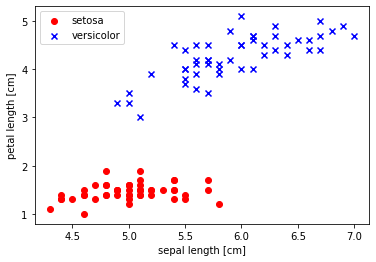

In [5]:
# scatter plot
plt.scatter(X[:50, 0], X[:50, 1], color='red', marker='o', label='setosa')
plt.scatter(X[50:100, 0], X[50:100, 1], color='blue', marker='x', label='versicolor')

plt.xlabel('sepal length [cm]')
plt.ylabel('petal length [cm]')
plt.legend(loc='upper left')

plt.show()

- 분포를 보니 선형 결정 경계로 구분할 수 있겠다.

#### 퍼셉트론 모델 훈련하기

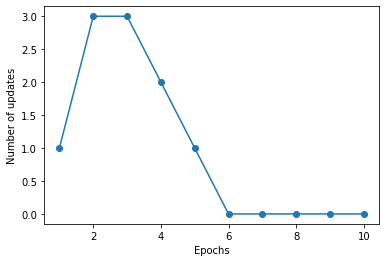

In [6]:
ppn = Perceptron(eta=0.1, n_iter=10)

ppn.fit(X, y)

plt.plot(range(1, len(ppn.errors_) + 1), ppn.errors_, marker='o')
    # 1부터 errors_ 리스트의 갯수까지가 X label인데,
        # errors_ 리스트는 epoch가 한 번 돌 때마다 추가되는 거니까, x축은 epoch다.
        # ppn.errors_ 각 epoch 당 error의 총합
plt.xlabel('Epochs')
plt.ylabel('Number of updates')

plt.show()

- epoch 6 이후로 퍼셉트론은 수렴한다.

#### 결정 경계 그래프 함수

In [7]:
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, resolution=0.02):
    
    # 마커와 컬러맵을 설정한다
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
        # np.unique(y)는 y의 unique value를 리스트로 반환 => len은 unique value의 개수
    
    # 결정 경계를 그린다
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        # 꽃받침 길이 최소/최대
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        # 꽃잎 길이 최소/최대
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                          np.arange(x2_min, x2_max, resolution))
        # meshgrid함수는 축에 해당하는 1차원 배열을 전달받아 벡터 공간의 모든 좌표를 담은 행렬을 반환한다.
    
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
            # ravel로 입력된 배열을 1차원으로 펼치고 => np.array로 두 배열을 묶어서 하나의 행렬로 만들고 => 이를 전치(T)하여 두 개의 열이 되도록 바꾼다.
            # ! 이제 이 두 열이 xy평면의 좌표값이다.
            # !! 그 각각의 xy좌표에 대해 predict를 수행하면 각각의 좌표마다 클래스예측값을 반환하는 거다.
    Z = Z.reshape(xx1.shape)
            # !!! 그 각각의 예측값을 지닌 1차원 배열을 meshgrid shape으로 다시 바꿔준다.
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    """contourf
    parameters
    ------------
    X, Y: array-like
      the coordinates of the values in Z.
    Z: array-like
      the height values over which the contour is drawn.
    """
    # Z의 shape을 xx1과 맞춰준 이유는..
        # xx1의 각 원소가 x좌표, xx2의 각 원소가 y좌표일 때,
        # Z의 각 원소는 각 x,y좌표의 'height value', 즉 class value가 되어야 하기 때문이다.
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    # 샘플의 산점도를 그린다
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0],
                   y=X[y == cl, 1],
                   alpha=0.8,
                   c=colors[idx],
                   marker=markers[idx],
                   label=cl,
                   edgecolor='black')
        
        # 위에서 X[y == cl, 0] 설명..
            # X에서 y == cl인 것들 중 0열의 데이터를 x로 두고
            # X에서 y == cl인 것들 중 1열의 데이터를 y로 둔다
            # 이렇게 되면 결국 좌표를 찍는 거다.
                # 클래스가 1인 feature 2개의 샘플데이터들을
                # feature별로 x,y좌표를 주고 산점도 위에 찍는다.
            # 똑같이 클래스가 -1인 feature 2개의 샘플데이터들을
            # feature별로 x,y 좌표를 주고 산점도 위에 찍는다.

In [8]:
X[y == 1, 0].shape

(50,)

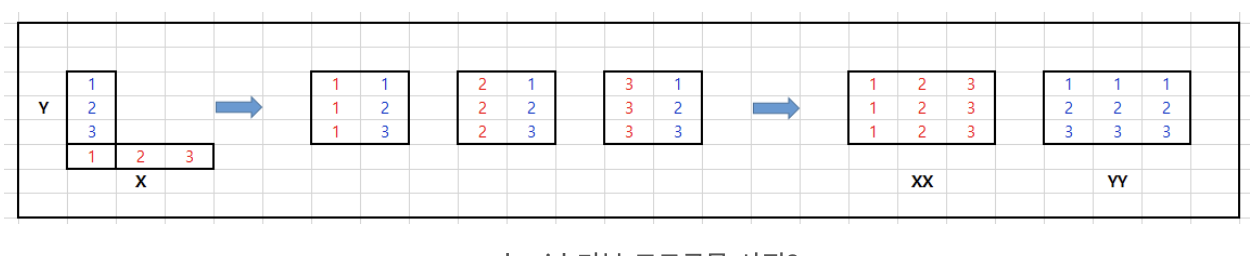

In [7]:
Image(filename='ch02/meshgrid.png', width=500)

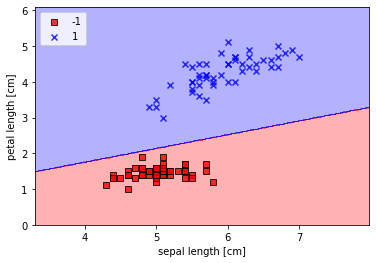

In [9]:
plot_decision_regions(X, y, classifier=ppn)
plt.xlabel('sepal length [cm]')
plt.ylabel('petal length [cm]')
plt.legend(loc='upper left')

plt.show()

In [10]:
x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1

resolution = 0.02
xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                          np.arange(x2_min, x2_max, resolution))

In [11]:
X[:, 1].max()

5.1

In [12]:
np.arange(x1_min, x1_max, 0.02).shape

(235,)

In [13]:
xx1, xx2

(array([[3.3 , 3.32, 3.34, ..., 7.94, 7.96, 7.98],
        [3.3 , 3.32, 3.34, ..., 7.94, 7.96, 7.98],
        [3.3 , 3.32, 3.34, ..., 7.94, 7.96, 7.98],
        ...,
        [3.3 , 3.32, 3.34, ..., 7.94, 7.96, 7.98],
        [3.3 , 3.32, 3.34, ..., 7.94, 7.96, 7.98],
        [3.3 , 3.32, 3.34, ..., 7.94, 7.96, 7.98]]),
 array([[0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
        [0.02, 0.02, 0.02, ..., 0.02, 0.02, 0.02],
        [0.04, 0.04, 0.04, ..., 0.04, 0.04, 0.04],
        ...,
        [6.04, 6.04, 6.04, ..., 6.04, 6.04, 6.04],
        [6.06, 6.06, 6.06, ..., 6.06, 6.06, 6.06],
        [6.08, 6.08, 6.08, ..., 6.08, 6.08, 6.08]]))

In [14]:
xx1.shape

(305, 235)

## 2.3 적응형 선형 뉴런과 학습의 수렴
- 적응형 선형 뉴런(ADAptive LInear NEuron, ADALINE)
- Rosenblatt가 퍼셉트론을 발표한지 채 몇 년이 지나지 않아 Bernard Widrow와 Tedd Hoff가 아달린(Adaline)을 발표했다.
    - 아달린은 퍼셉트론의 향상된 버전이다.
    - 아달린은 연속 함수(continuous function)로 비용 함수를 정의하고 최소화하는 핵심 개념을 보여준다.

> 아달린 규칙(aka 위드로우-호프 규칙)과 로젠블라트 퍼셉트론의 가장 큰 차이점은 가중치를 업데이트하는 데 퍼셉트론처럼 unit step function 대신 linear activation function을 쓴다는 것이다.

아달린의 선형 활성화 함수는 단순한 항등 함수(identity function)다.<br><br>
$$\phi(z) = z$$

In [9]:
Image(url='https://git.io/JtIbn', width=500) 

> 아달린 알고리즘은 **진짜 클래스 레이블**과 **선형 활성화 함수의 실수 출력 값**을 비교하여 모델의 오차를 계산하고 가중치를 업데이트한다.

> 퍼셉트론은 **진짜 클래스 레이블**과 **예측 클래스 레이블**을 비교한다.

### 2.3.1 경사 하강법으로 비용 함수 최소화

목적 함수 == 비용 함수 == 손실 함수<br>

> 아달린은 "activation 출력"과 "진짜 클래스 레이블" 사이의 **제곱 오차합(SSE)** 으로 가중치를 학습하기 위한 비용 함수 J를 정의한다. <br>

$J(\boldsymbol{w})=\dfrac{1}{2}\sum_i\left(y^{(i)}-\phi(z^{(i)})\right)^2$

- 위에서 1/2 항은 가중치 파라미터에 대한 비용 함수 또는 손실 함수의 그라디언트를 간소하게 만들려고 편의상 추가한 것임

> unit step function 대신 continuous linear activation function을 사용하는 장점은 비용 함수가 미분 가능해진다는 것이다.

> 또 다른 장점은 이 함수가 볼록 함수라는 것이다. => 경사 하강법을 사용할 수 있다는 말이다.
>> "비용 함수 $J(w)$의 그라디언트 $\nabla J(w)$ 반대 방향으로 조금씩 가중치를 업데이트할 수 있다."<br>

- 가중치 변화량 $\Delta w$는 음수의 그라디언트에 학습률 $\eta$를 곱한 것으로 정의한다.

- 아래는 비용함수의 그라디언트를 계산하기 위해 각 가중치 $w_j$에 대한 편도 함수를 계산하는 과정이다.<br><br>
$\
\begin{align*}
\dfrac{\partial J}{\partial w_j}\
&=\dfrac{\partial}{\partial w_j}\dfrac{1}{2}\sum_i\left(y^{(i)}-\phi(z^{(i)})\right)^2 \\
&=\dfrac{1}{2}\dfrac{\partial}{\partial w_j}\sum_i\left(y^{(i)}-\phi(z^{(i)})\right)^2 \\
&=\dfrac{1}{2}\sum_i2\left(y^{(i)}-\phi(z^{(i)})\right)\dfrac{\partial}{\partial w_j}\left(y^{(i)}-\phi(z^{(i)})\right) \\
&=\sum_i\left(y^{(i)}-\phi(z^{(i)})\right)\dfrac{\partial}{\partial w_j}\left(y^{(i)}-\sum(w_kx_k^{(i)})\right) \\
&=\sum_i\left(y^{(i)}-\phi(z^{(i)})\right)\left(-x_j^{(i)}\right) \\
&=-\sum_i\left(y^{(i)}-\phi(z^{(i)})\right)x_j^{(i)} \\
\end{align*}
$

$\mathit\Delta w_j=-\eta\dfrac{\partial J}{\partial w_j}=\eta\sum_i\left(y^{(i)}-\phi(z^{(i)})\right)x_j^{(i)}$

$\boldsymbol{w} := \boldsymbol{w} + \mathit\Delta \boldsymbol{w}$

### 2.3.2 파이썬으로 아달린 구현

In [16]:
class AdalineGD(object):
    """적응형 선형 뉴런 분류기
    
    매개변수
    -----------
    eta : float
      학습률 (0.0과 1.0 사이)
    n_iter : int
      훈련 데이터셋 반복 횟수
    random_state : int
      가중치 무작위 초기화를 위한 난수 생성기 시드
      
    속성
    -----------
    w_ : 1d-array
      학습된 가중치
    cost_ : list
      에포크마다 누적된 비용 함수의 제곱합    
    """
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state
        
    def fit(self, X, y):
        """훈련 데이터 학습
        
        매개변수
        ---------
        X : array-like, shape = [n_samples, n_features]
        y : array-like, shape = [n_samples]
        
        
        반환값
        ---------
        self : object
        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.cost_ = []
        
        for i in range(self.n_iter):
            net_input = self.net_input(X)
            # 이 코드의 활성화 함수는 항등함수이기 때문에 아무런 효과가 없다.
            # 이 대신 'output = self.net_input(X)'로 바로 쓸 수 있다.
            # 아래 활성화 함수는 개념적인 목적을 위해 만들었다.
            output = self.activation(net_input)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
                # 이 식은 위에 있던 편도함수의 식과 같다.
            self.w_[0] += self.eta * errors.sum()
            cost = (errors**2).sum() / 2.0
            self.cost_.append(cost)
        return self
    
    def net_input(self, X):
        """최종 입력 계산"""
        return np.dot(X, self.w_[1:]) + self.w_[0]
    
    def activation(self, X):
        """선형 활성화 계산"""
        return X
    
    def predict(self, X):
        """단위 계단 함수를 사용하여 클래스 레이블을 반환한다"""
        return np.where(self.activation(self.net_input(X)) >= 0.0, 1, -1)

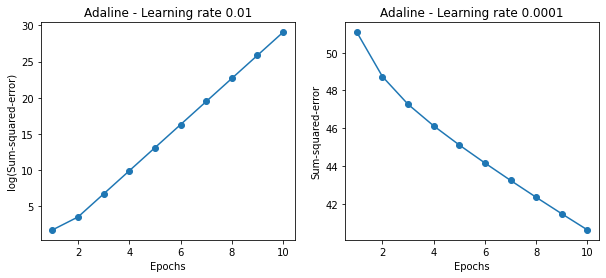

In [17]:
# 두 학습률, eta=0.01과 eta=0.0001에서 "에포크 횟수 대비 비용 그래프"
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

ada1 = AdalineGD(n_iter=10, eta=0.01).fit(X, y)
ax[0].plot(range(1, len(ada1.cost_) + 1),
          np.log10(ada1.cost_), marker='o')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('log(Sum-squared-error)')
ax[0].set_title('Adaline - Learning rate 0.01')

ada2 = AdalineGD(n_iter=10, eta=0.0001).fit(X, y)
ax[1].plot(range(1, len(ada2.cost_) + 1), ada2.cost_, marker='o')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Sum-squared-error')
ax[1].set_title('Adaline - Learning rate 0.0001')

plt.show()

- 왼쪽의 경우 학습률이 너무 큰 것이다.
    - 에포크가 지날수록 비용함수는 최소화되긴 커녕 오차가 점점 커진다. = 전역 최솟값을 지나친 것이다.
- 오른쪽의 경우 비용은 꾸준히 감소하지만 학습률이 너무 작기 때문에 알고리즘이 전역 최솟값에 수렴하려면 아주 많은 에포크가 필요하다.

### 2.3.3 특성 스케일을 조정하여 경사 하강법 결과 향상

> 경사 하강법은 특성 스케일을 조정하여 혜택을 볼 수 있는 많은 알고리즘 중 하나다.<br>

- 표준화(standardization)은 데이터가 평균이 0이고 단위 분산을 갖는 표준정규분포가 되도록 만들어준다. => 경사 하강법 학습이 좀 더 빠르게 수렴된다.
- j번째 특성을 표준화하는 것은 => j번째 특성의 모든 샘플에서 평균 $\mu_j$를 빼고 표준편차 $\sigma_j$로 나누는 것이다.<br>
$$\boldsymbol{x}'_j=\dfrac{\boldsymbol{x}_j-\mu_j}{\sigma_j}$$

In [18]:
Image(url='https://git.io/JtIbB', width=700) 

- 왼쪽은 표준화하지 않은 데이터셋, 오른쪽은 표준화한 데이터셋이다.
- global cost minimum에 도달하는 거리가 더 짧아진다.

In [19]:
# np를 활용해 표준화한다
X_std = np.copy(X)
X_std[:, 0] = (X[:, 0] - X[:, 0].mean()) / X[:, 0].std()
X_std[:, 1] = (X[:, 1] - X[:, 1].mean()) / X[:, 1].std()

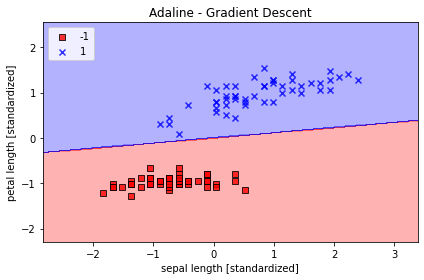

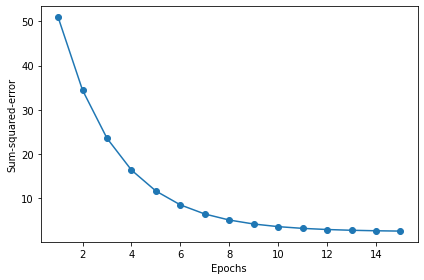

In [20]:
# 다시 adalin 모델을 사용해본다
ada_gd = AdalineGD(n_iter=15, eta=0.01)
ada_gd.fit(X_std, y)

plot_decision_regions(X_std, y, classifier=ada_gd)
plt.title('Adaline - Gradient Descent')
plt.xlabel('sepal length [standardized]')
plt.ylabel('petal length [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

plt.plot(range(1, len(ada_gd.cost_) + 1), ada_gd.cost_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Sum-squared-error')
plt.tight_layout()
plt.show()

### 2.3.4 대규모 머신 러닝과 확률적 경사 하강법 (Stochastic Gradient Descent)
- 위에서 지금까지 한 것은 배치 경사 하강법(Batch Gradient Descent)다.
    - 배치 방식이라는 건, "훈련 데이터셋에 있는 **모든 샘플을 기반으로** 가중치 업데이트를 계산하는 것이다."
    - 배치 방식의 경우 데이터셋의 규모가 아주 커지면 계산 비용이 매우 많이 든다. 전역 최솟값을 찾는 단계마다 매번 전체 훈련 데이터셋을 다시 평가해야 하기 때문이다.
- 확률적 경사 하강법(aka 반복/온라인 경사 하강법)은 배치 처럼 모든 샘플 $x^{(i)}$에 대해 누적된 오차합을 기반으로 가중치를 업데이트하는 것이 아니라, **각 훈련 샘플에 대해 조금씩 가중치를 업데이트한다.**<br><br>
    - 온라인 학습으로도 사용할 수 있다는 장점: 모델이 새로운 훈련 데이터가 도착하는 대로 실시간으로 훈련해야 할 때 사용하기 좋다.<br><br>
    
Batch Gradient: $\mathit\Delta \boldsymbol{w}=\eta\sum_i\left(y^{(i)}-\phi(z^{(i)})\right)\boldsymbol{x}^{(i)}$<br>

Stochastic Gradient: $\mathit\Delta \boldsymbol{w}=\eta\left(y^{(i)}-\phi(z^{(i)})\right)\boldsymbol{x}^{(i)}$

- 전체 훈련 샘플의 누적된 오차합이 아니라 **하나의 훈련 샘플을 기반으로 가중치가 계산된다.**
- 가중치가 훨씬 더 자주 업데이트된다는 얘기고, 그렇기에 수렴 속도가 빠르다.
- 중요한 점은..
    - 훈련 샘플 순서를 무작위로 주입해야 하고,
    - 순환되지 않도록 에포크마다 훈련 데이터셋을 섞어줘야 한다.<br>
    
> Stochastic에서는 종종 고정된 학습률 eta를 시간이 지남에 따라 적응적 학습률로 대체한다. (학습률을 n_iter에 따라 줄여나감으로써, 전역 최솟값에 더욱 근접할 수 있도록 해준다.)

- Batch와 Stochastic의 절충안으로 **mini-batch learning**도 있다.
    - 훈련 데이터의 작은 일부분으로 배치 경사 하강법을 적용하는 것이다. e.g. 한 번에 32개의 샘플을 사용하는 식이다.

In [21]:
class AdalineSGD(object):
    """ADAptive LInear NEuron 분류기
    
    Parameters
    -------------
    eta : float
    n_iter : int
    shuffle : bool (default: True)
      True로 설정하면 같은 반복이 되지 않도록 에포크마다 훈련 데이터를 섞는다.
    random_state : int
    
    Attributes
    -------------
    w_ : 1d-array
      학습된 가중치
    cost_ : list
      모든 훈련 샘플에 대해 에포크마다 누적된 평균 비용 함수의 제곱합
    """
    # 주제 벗어난 이야기지만, parameter로 받지 않았는데 self.에 입력시키는 attribute에는 underscore(_)를 붙인다.
    def __init__(self, eta=0.01, n_iter=10, shuffle=True, random_state=None):
        self.eta = eta
        self.n_iter = n_iter
        self.w_initialized = False
        self.shuffle = shuffle
        self.random_state = random_state
        
    def fit(self, X, y):
        # epoch를 1번 돌때, 가중치 학습이 X.shape[0]번 만큼 일어나는 것이다.
        self._initialize_weights(X.shape[1])
        self.cost_ = []
        for i in range(self.n_iter):
            if self.shuffle: # class parameter의 default가 True다.
                X, y = self._shuffle(X, y)
            cost = []
            for xi, target in zip(X, y):
                cost.append(self._update_weights(xi, target))
                # self._update_weights할 때 이미 weight update는 일어났다.
                # 근데 _update_weights의 return값은 cost니까, 이걸
                # cost에 append 한다. 이걸 샘플데이터 갯수만큼 반복하고
                # 샘플데이터 갯수로 나눠주면 avg_cost, 즉 이번 epoch의
                # avg_cost가 되는 것이다.
            avg_cost = sum(cost) / len(y)
            self.cost_.append(avg_cost)
        return self
    
    def partial_fit(self, X, y):
        """가중치를 다시 초기화하지 않고 훈련 데이터를 학습한다.
        (온라인 학습 활용)"""
        if not self.w_initialized:
            self._initialize_weights(X.shape[1])
        if y.ravel().shape[0] > 1:
            for xi, target in zip(X, y):
                self._update_weights(xi, target)
                # 2개 이상이면 zip으로 하나씩 빼고
        else:
            self._update_weights(X, y)
                # 1개면 zip할 필요 없으니까 1개의 샘플을 가지고 그대로 _update_weights 한다.
        return self
    
    def _shuffle(self, X, y):
        """훈련 데이터를 섞는다"""
        r = self.rgen.permutation(len(y))  # self.rgen은 fit메서드의 앞 단계에서 _initialize_weights 하면서 생성되어 있다.
        return X[r], y[r]
    
    def _initialize_weights(self, m): # m = X.shape[1] (feature 개수)
        """랜덤한 작은 수로 가중치를 초기화한다"""
        self.rgen = np.random.RandomState(self.random_state)
        self.w_ = self.rgen.normal(loc=0.0, scale=0.01, size=1 + m)
        self.w_initialized = True
    
    def _update_weights(self, xi, target):
        """아달린 학습 규칙을 적용하여 가중치를 업데이트한다"""
        output = self.activation(self.net_input(xi))
        error = (target - output)
        self.w_[1:] += self.eta * xi.dot(error)
        self.w_[0] += self.eta * error
        cost = 0.5 * error**2
        return cost
    
    def net_input(self, X):
        """입력 계산"""
        return np.dot(X, self.w_[1:]) + self.w_[0]
    
    def activation(self, X):
        """선형 활성화 계산"""
        return X
    
    def predict(self, X):
        """단위 계단 함수를 사용하여 클래스 레이블을 반환"""
        return np.where(self.activation(self.net_input(X)) >= 0.0, 1, -1)

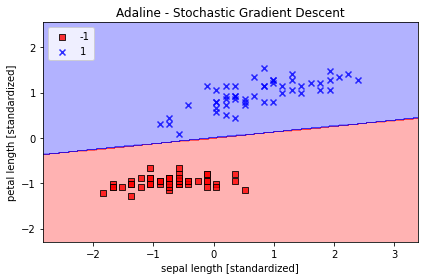

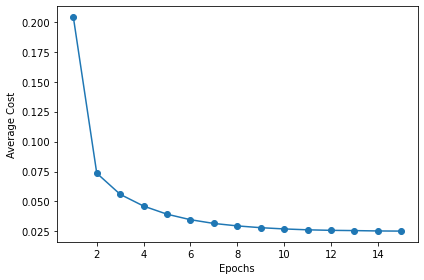

In [22]:
# visualize the result
ada_sgd = AdalineSGD(n_iter=15, eta=0.01, random_state=1)
ada_sgd.fit(X_std, y)

plot_decision_regions(X_std, y, classifier=ada_sgd)
plt.title('Adaline - Stochastic Gradient Descent')
plt.xlabel('sepal length [standardized]')
plt.ylabel('petal length [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

plt.plot(range(1, len(ada_sgd.cost_) + 1), ada_sgd.cost_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Average Cost')
plt.tight_layout()
plt.show()

In [23]:
# 온라인 학습 방식으로 모델을 훈련하려면 개개의 샘플마다
    # partial_fit 메서드를 호출하면 된다.
ada_sgd.partial_fit(X_std[0, :], y[0])